In [ ]:
%matplotlib inline


# Pipelining: chaining a PCA and a logistic regression

The PCA does an unsupervised dimensionality reduction, while the logistic
regression does the prediction.

We use a GridSearchCV to set the dimensionality of the PCA


(1797, 64)
(1797,)
Best parameter (CV score=0.874):
{'logistic__C': np.float64(21.54434690031882), 'pca__n_components': 60}
[1.00000000e-04 4.64158883e-02 2.15443469e+01 1.00000000e+04]


/tmp/ipython-input-2695707252.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_clfs = results.groupby(components_col).apply(


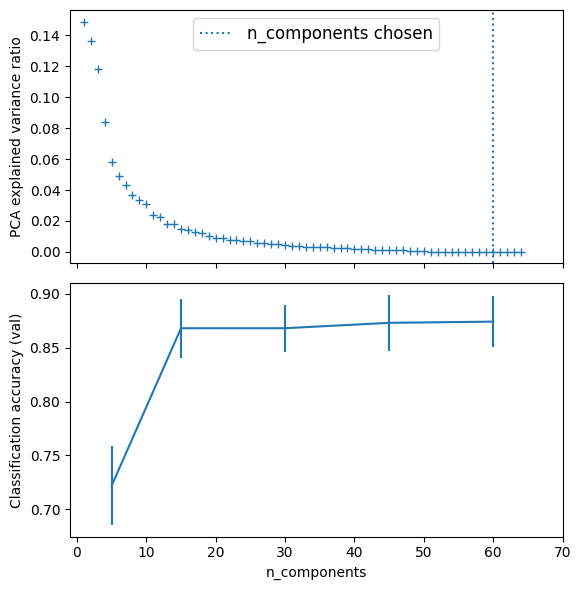

In [ ]:
# 📘 Ejemplo de PCA + Regresión Logística con GridSearchCV

# Importamos librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# Definimos los pasos del pipeline:
# 1. Escalamos los datos (StandardScaler)
# 2. Reducimos la dimensionalidad con PCA
# 3. Clasificamos con Regresión Logística
pca = PCA()
scaler = StandardScaler()
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[("scaler", scaler), ("pca", pca), ("logistic", logistic)])

# Cargamos el dataset de dígitos (imágenes 8x8, 1797 ejemplos)
X_digits, y_digits = datasets.load_digits(return_X_y=True)
print(X_digits.shape)  # (1797, 64)
print(y_digits.shape)  # (1797,)

# Definimos la grilla de hiperparámetros:
# - n_components: cuántos componentes PCA conservar
# - C: parámetro de regularización de la Regresión Logística
param_grid = {
    "pca__n_components": [5, 15, 30, 45, 60],
    "logistic__C": np.logspace(-4, 4, 4),  # 4 valores entre 1e-4 y 1e4
}

# GridSearchCV probará todas las combinaciones de la grilla
# y buscará la mejor según validación cruzada
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_digits, y_digits)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
print(np.logspace(-4, 4, 4))

# ============================================================
# 📊 Parte 1: Gráfico del espectro PCA
# ============================================================

pca.fit(X_digits)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))

# Varianza explicada por cada componente PCA
ax0.plot(
    np.arange(1, pca.n_components_ + 1), 
    pca.explained_variance_ratio_, 
    "+", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")

# Línea vertical indicando el número de componentes elegido por GridSearch
ax0.axvline(
    search.best_estimator_.named_steps["pca"].n_components,
    linestyle=":",
    label="n_components chosen",
)
ax0.legend(prop=dict(size=12))

# ============================================================
# 📊 Parte 2: Resultados de validación cruzada
# ============================================================

# Convertimos resultados del GridSearch en DataFrame
results = pd.DataFrame(search.cv_results_)
components_col = "param_pca__n_components"

# Para cada número de componentes PCA, elegimos el mejor clasificador
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, "mean_test_score")
)

# Graficamos la accuracy en función del número de componentes
best_clfs.plot(
    x=components_col, y="mean_test_score", yerr="std_test_score",
    legend=False, ax=ax1
)
ax1.set_ylabel("Classification accuracy (val)")
ax1.set_xlabel("n_components")

# Ajustamos escala del gráfico
plt.xlim(-1, 70)
plt.tight_layout()
plt.show()


In [ ]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logistic__C,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.063546,0.025516,0.003310,0.002528,0.0001,5,"{'logistic__C': 0.0001, 'pca__n_components': 5}",0.677778,0.688889,0.662953,0.774373,0.615599,0.683918,0.051675,20
1,0.038557,0.011633,0.002148,0.000246,0.0001,15,"{'logistic__C': 0.0001, 'pca__n_components': 15}",0.780556,0.761111,0.788301,0.852368,0.732591,0.782985,0.039664,16
2,0.069235,0.016182,0.003524,0.001475,0.0001,30,"{'logistic__C': 0.0001, 'pca__n_components': 30}",0.800000,0.808333,0.802228,0.863510,0.760446,0.806903,0.032967,15
3,0.181974,0.065684,0.010837,0.004082,0.0001,45,"{'logistic__C': 0.0001, 'pca__n_components': 45}",0.808333,0.808333,0.810585,0.871866,0.757660,0.811356,0.036231,13
4,0.163322,0.039862,0.009089,0.003718,0.0001,60,"{'logistic__C': 0.0001, 'pca__n_components': 60}",0.805556,0.808333,0.810585,0.871866,0.757660,0.810800,0.036295,14
5,0.227711,0.029824,0.006539,0.005143,0.046416,5,"{'logistic__C': 0.046415888336127774, 'pca__n_...",0.791667,0.738889,0.768802,0.830084,0.735376,0.772963,0.035224,17
6,0.201068,0.031461,0.006698,0.002447,0.046416,15,"{'logistic__C': 0.046415888336127774, 'pca__n_...",0.900000,0.877778,0.913649,0.941504,0.857939,0.898174,0.028828,8
7,0.267366,0.029099,0.005905,0.001957,0.046416,30,"{'logistic__C': 0.046415888336127774, 'pca__n_...",0.922222,0.891667,0.930362,0.947075,0.877437,0.913753,0.025552,4
8,0.337958,0.078173,0.007846,0.004182,0.046416,45,"{'logistic__C': 0.046415888336127774, 'pca__n_...",0.927778,0.894444,0.941504,0.966574,0.883008,0.922662,0.030588,2
9,0.342546,0.052816,0.013760,0.005876,0.046416,60,"{'logistic__C': 0.046415888336127774, 'pca__n_...",0.922222,0.900000,0.944290,0.966574,0.885794,0.923776,0.029199,1
